# Named Entity Recognition (NER) Notebook

## Introduction
Named Entity Recognition (NER) is a crucial task in Natural Language Processing (NLP) that involves identifying and extracting specific entities, such as names of people, organizations, locations, dates, etc., from unstructured text data. This notebook aims to explore the fundamentals of NER, techniques for building NER models, and applications in various fields.

- geo = Geographical Entity

- org = Organization

- per = Person

- gpe = Geopolitical Entity

- tim = Time indicator

- art = Artifact

- eve = Event

- nat = Natural Phenomenon

### Dataset Overview
- **Dataset:** [Named Entity Recognition (NER) Corpus](https://www.kaggle.com/datasets/naseralqaydeh/named-entity-recognition-ner-corpus)
- **Purpose:** Extract structured data from unstructured text
- **Entities:** Includes various types like persons, organizations, locations, etc.
- **Size:** Details about the size and structure of the dataset

Let's dive into the world of Named Entity Recognition and understand how it can be applied to extract valuable information from text data.


## Import Required Dependencies

In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Dense, Bidirectional, LSTM,Embedding, TimeDistributed, Dropout
from keras.models import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from spacy import displacy
Text_Visualization = spacy.load('en_core_web_sm')

In [3]:
data = pd.read_csv("ner.csv")

In [4]:
data.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


## Data Preprocessing

In [5]:
def preprocess_data(data):
    for i in range(len(data)):     # This loop iterates over each row in the DataFrame.
        pos = ast.literal_eval(data['POS'][i])  # converts these string representations back into actual Python lists
        tags = ast.literal_eval(data['Tag'][i])
        data['POS'][i] = [str(word) for word in pos]  #  converts each element to a string
        data['Tag'][i] = [str(word.upper()) for word in tags]
    return data

In [6]:
data = preprocess_data(data)
data.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"[NNS, IN, NNS, VBN, IN, DT, NN, VBD, DT, NNS, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"[PRP, VBD, IN, DT, NNS, IN, NN, TO, DT, NN, IN...","[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","[NNS, VBD, DT, NN, IN, NNS, IN, CD, IN, NNS, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 5,The protest comes on the eve of the annual con...,"[DT, NN, VBZ, IN, DT, NN, IN, DT, JJ, NN, IN, ...","[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,..."


- Clean Data: It converts the data in the 'POS' and 'Tag' columns from their string representations to proper lists. This is often necessary to work with this data effectively.

- Normalize Case: It converts the tags in the 'Tag' column to uppercase, which can help with consistency and analysis.

In [7]:
data["Tag"][0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GEO',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GEO',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GPE',
 'O',
 'O',
 'O',
 'O',
 'O']

## Train Test Split

In [8]:
split_col = data[['Sentence','Tag']]

train,test = train_test_split(split_col,test_size=0.2,random_state=42)
len(train),len(test)

(38367, 9592)

## Tokenization

In [9]:
# Covert sentences to sequances
train_targets = list(train.Tag.values)
test_targets = list(test.Tag.values)

tokenizer = Tokenizer(lower=False,oov_token="UNK")   # Not to convert words to lower becouse of case sensitivity

# Creates a vocabulary of words from the training data.
# Assigns unique integers to each word in the vocabulary (word to index).
tokenizer.fit_on_texts(train['Sentence'])

train_inputs = tokenizer.texts_to_sequences(train['Sentence']) # convert data to integers
test_inputs = tokenizer.texts_to_sequences(test['Sentence'])

- Label Extraction: Creating lists of target labels for the training and testing data.

- Tokenization: Building a vocabulary from the training sentences and creating a tokenizer to convert words to integers.

- Sequence Conversion: Transforming the sentences into numerical sequences that can be used as input for a neural network model.

In [10]:
# Mapping words to integers
word_to_indx = tokenizer.word_index
Vocab_SIze = len(word_to_indx) 
print(f"Found {Vocab_SIze} unique tokens")

Found 28761 unique tokens


In [11]:
tokenizer.word_index

{'UNK': 1,
 'the': 2,
 'in': 3,
 'of': 4,
 'to': 5,
 'a': 6,
 'and': 7,
 'The': 8,
 "'s": 9,
 'for': 10,
 'has': 11,
 'on': 12,
 'is': 13,
 'that': 14,
 'U': 15,
 'have': 16,
 'with': 17,
 'said': 18,
 'was': 19,
 'S': 20,
 'says': 21,
 'by': 22,
 'from': 23,
 'at': 24,
 'say': 25,
 'as': 26,
 'an': 27,
 'are': 28,
 'were': 29,
 'will': 30,
 'his': 31,
 'government': 32,
 'Mr': 33,
 'it': 34,
 'been': 35,
 'killed': 36,
 'two': 37,
 'he': 38,
 'not': 39,
 'people': 40,
 'officials': 41,
 'its': 42,
 'after': 43,
 'be': 44,
 'President': 45,
 'A': 46,
 'year': 47,
 'also': 48,
 'more': 49,
 'United': 50,
 'military': 51,
 'country': 52,
 'than': 53,
 'who': 54,
 'they': 55,
 'Iraq': 56,
 'In': 57,
 'but': 58,
 'their': 59,
 'last': 60,
 'one': 61,
 'He': 62,
 'which': 63,
 'had': 64,
 'new': 65,
 'least': 66,
 'about': 67,
 'other': 68,
 'this': 69,
 'police': 70,
 'States': 71,
 'Tuesday': 72,
 'week': 73,
 'three': 74,
 'Thursday': 75,
 'Friday': 76,
 'forces': 77,
 'over': 78,
 'Iran

In [12]:
# Unique Tags
train_tags = set([val for sublist in train_targets for val in sublist])
test_tags = set([val for sublist in test_targets for val in sublist])

print("Unique NER tags in train set: ",train_tags)
print("Unique NER tags in test set: ",test_tags)

Unique NER tags in train set:  {'I-ORG', 'B-PER', 'I-GPE', 'B-EVE', 'I-PER', 'B-TIM', 'B-ORG', 'I-TIM', 'B-GPE', 'I-GEO', 'I-NAT', 'B-ART', 'B-NAT', 'I-EVE', 'I-ART', 'O', 'B-GEO'}
Unique NER tags in test set:  {'I-ORG', 'B-PER', 'I-GPE', 'B-EVE', 'I-PER', 'B-TIM', 'B-ORG', 'I-TIM', 'B-GPE', 'I-GEO', 'B-ART', 'I-ART', 'B-NAT', 'I-EVE', 'I-NAT', 'O', 'B-GEO'}


In [13]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_tgt_int = tag_tokenizer.texts_to_sequences(train_targets)
test_tgt_int = tag_tokenizer.texts_to_sequences(test_targets)

In [14]:
# Max length
max_length_train = max(len(sent) for sent in train_inputs)
max_length_test = max(len(sent) for sent in test_inputs)
max_length = max(max_length_train,max_length_test)

# Pad input sequences
train_inputs_final = pad_sequences(train_inputs,maxlen=max_length,padding="post")
print("Shape of train inputs: ",train_inputs_final.shape)

test_inputs_final = pad_sequences(test_inputs,maxlen=max_length,padding="post")
print("Shape of test inputs: ",test_inputs_final.shape)

train_targets_final = pad_sequences(train_tgt_int,maxlen=max_length,padding="post")
print("Shape of train targets: ",train_targets_final.shape)

test_targets_final = pad_sequences(test_tgt_int,maxlen=max_length,padding="post")
print("Shape of test targets: ",test_targets_final.shape)

Shape of train inputs:  (38367, 89)
Shape of test inputs:  (9592, 89)
Shape of train targets:  (38367, 89)
Shape of test targets:  (9592, 89)


In [15]:
num_tags = len(tag_tokenizer.word_index) + 1
num_tags

18

In [16]:
# Save tokenizers
with open('D:\DEPI Generative AI Professional\Week 10\Entity Recognition Task\\tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [17]:
with open('D:\DEPI Generative AI Professional\Week 10\Entity Recognition Task\\tag_tokenizer.pkl', 'wb') as f:
    pickle.dump(tag_tokenizer, f)

## NN Model

In [18]:
model = Sequential()
model.add(Embedding(input_dim=Vocab_SIze+1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

In [19]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 89, 128)           3681536   
                                                                 
 bidirectional (Bidirection  (None, 89, 256)           263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 256)           0         
                                                                 
 time_distributed (TimeDist  (None, 89, 18)            4626      
 ributed)                                                        
                                                                 
Total params: 3949330 (15.07 MB)
Trainable params: 3949330 (15.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_inputs_final, train_targets_final,
    validation_data=(test_inputs_final, test_targets_final),
    batch_size=64,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15


600/600 [==============================] - 136s 213ms/step - loss: 0.1250 - accuracy: 0.9625 - val_loss: 0.0852 - val_accuracy: 0.9719
Epoch 2/15
600/600 [==============================] - 112s 187ms/step - loss: 0.0756 - accuracy: 0.9743 - val_loss: 0.0828 - val_accuracy: 0.9733
Epoch 3/15
600/600 [==============================] - 117s 194ms/step - loss: 0.0624 - accuracy: 0.9785 - val_loss: 0.0848 - val_accuracy: 0.9732
Epoch 4/15
600/600 [==============================] - 117s 195ms/step - loss: 0.0549 - accuracy: 0.9810 - val_loss: 0.0876 - val_accuracy: 0.9727
Epoch 5/15
600/600 [==============================] - 124s 207ms/step - loss: 0.0499 - accuracy: 0.9827 - val_loss: 0.0916 - val_accuracy: 0.9733


In [22]:
model.save('Recognition.keras')

In [23]:
model = keras.models.load_model(r"D:\DEPI Generative AI Professional\Week 10\Entity Recognition Task\Recognition.keras")

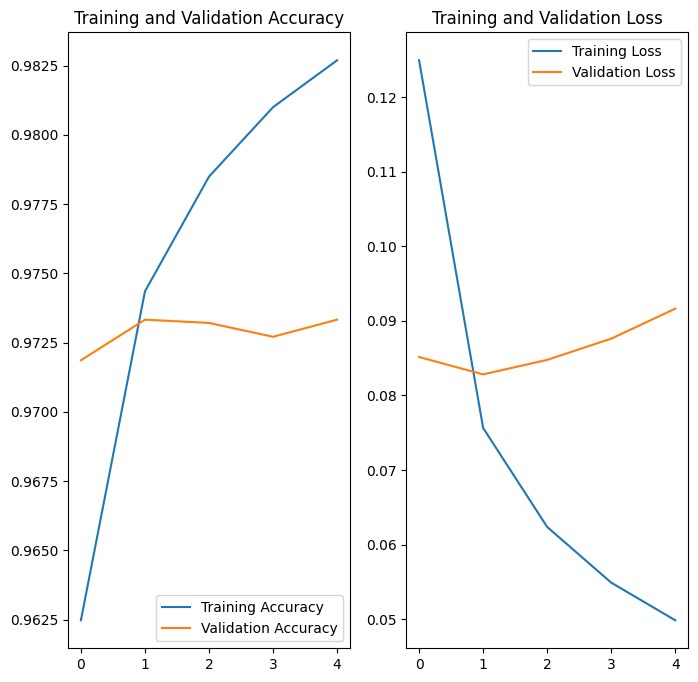

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = len(acc)  # Get the number of epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy') # Use range(epochs) directly
plt.plot(range(epochs), val_acc, label='Validation Accuracy') # Use range(epochs) directly
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss') # Use range(epochs) directly
plt.plot(range(epochs), val_loss, label='Validation Loss') # Use range(epochs) directly
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 


## Inference

In [25]:

 
def get_entities(sentence):
    """
    Predict named entities in a given sentence.
    
    Args:
        sentence (str): The input sentence.
        
    Returns:
        A list of tuples, where each tuple contains the entity text and its corresponding entity type.
    """
    # Preprocess the input sentence
    input_seq = tokenizer.texts_to_sequences([sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_length, padding="post")
    
    # Make predictions
    predictions = model.predict(input_seq)
    predicted_tags = np.argmax(predictions, axis=-1)[0]
    
    # Map the predicted tags back to their corresponding entity types
    entities = []
    for i, tag in enumerate(predicted_tags):
        if tag != 0:  # Ignore padding
            entity_type = tag_tokenizer.index_word[tag]
            entity_text = sentence.split()[i]
            entities.append((entity_text, entity_type))
    
    return entities

In [26]:
sample_sentence = "The International Atomic Energy Agency is to hold second day of talks in Vienna Wednesday on how to respond to Iran 's resumption of low-level uranium conversion ."
entities = get_entities(sample_sentence)
print(entities)


1/1 [==============================] - 1s 1s/step
[('The', 'o'), ('International', 'b-org'), ('Atomic', 'i-org'), ('Energy', 'i-org'), ('Agency', 'i-org'), ('is', 'o'), ('to', 'o'), ('hold', 'o'), ('second', 'o'), ('day', 'o'), ('of', 'o'), ('talks', 'o'), ('in', 'o'), ('Vienna', 'b-geo'), ('Wednesday', 'b-tim'), ('on', 'o'), ('how', 'o'), ('to', 'o'), ('respond', 'o'), ('to', 'o'), ('Iran', 'o'), ("'s", 'o'), ('resumption', 'o'), ('of', 'o'), ('low-level', 'o'), ('uranium', 'o'), ('conversion', 'o'), ('.', 'o')]


In [27]:
Entity = data['Sentence'][:10].apply(lambda x : Text_Visualization(x))
displacy.render(Entity, jupyter = True, style = 'ent')

1/1 [==============================] - 0s 40ms/step


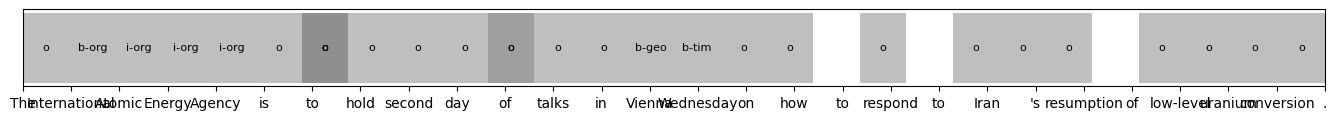

In [28]:
def visualize_entities(sentence, entities):
  """Visualizes named entities in a sentence using matplotlib.

  Args:
    sentence (str): The sentence to visualize.
    entities (list): A list of tuples, where each tuple contains an entity and its type.
  """
  words = sentence.split()
  fig, ax = plt.subplots(figsize=(len(words) * 0.6, 1))  # Adjust figure size dynamically
  ax.set_xticks(range(len(words)))
  ax.set_xticklabels(words)
  ax.set_yticks([])  # Hide y-axis

  for entity, entity_type in entities:
    start_index = words.index(entity)
    end_index = start_index + 1
    ax.axhspan(0, 1, xmin=start_index / len(words), xmax=end_index / len(words), facecolor=get_color(entity_type), alpha=0.5)
    ax.annotate(entity_type, xy=((start_index + end_index) / 2 / len(words), 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8)

  plt.show()

def get_color(entity_type):
  """Assigns a color to each entity type."""
  color_map = {
    'ORG': 'blue',
    'GPE': 'green',
    'PERSON': 'red',
    'TIM': 'yellow',
    'ART': 'purple',
    'EVE': 'orange',
    'NAT': 'brown'
  }
  return color_map.get(entity_type, 'gray')  # Default color is gray

# Example usage:
sample_sentence = "The International Atomic Energy Agency is to hold second day of talks in Vienna Wednesday on how to respond to Iran 's resumption of low-level uranium conversion ."
entities = get_entities(sample_sentence)
visualize_entities(sample_sentence, entities)


1/1 [==============================] - 0s 40ms/step


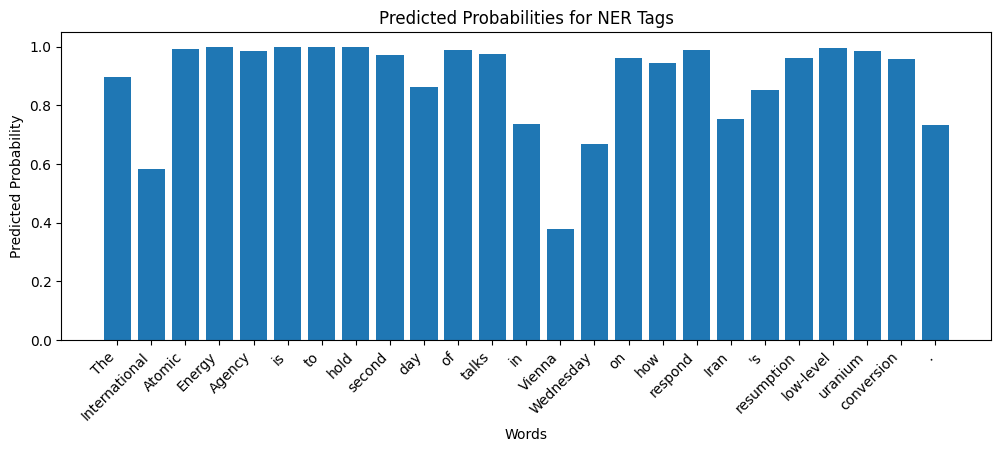

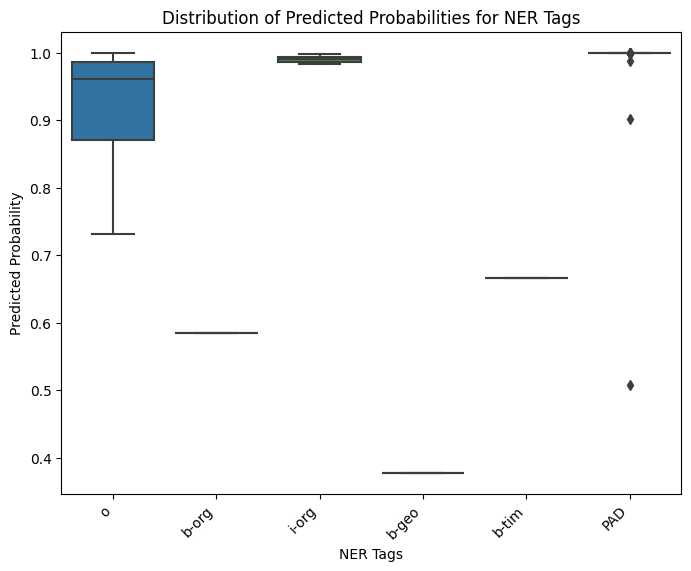

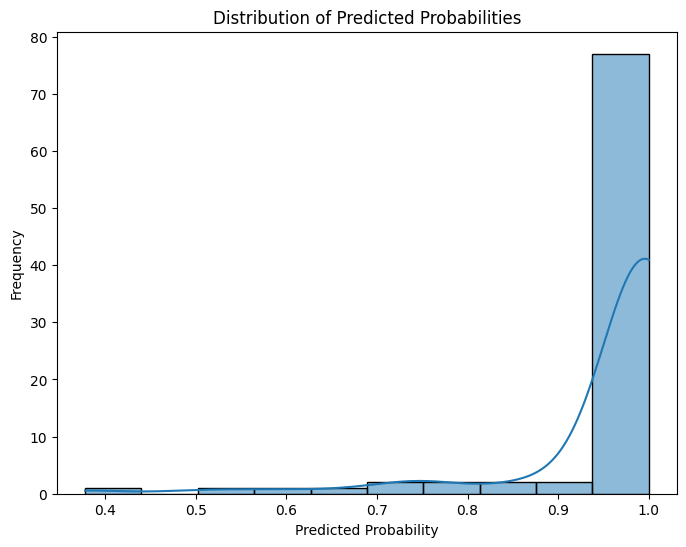

C:\Users\Marwa\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Marwa\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


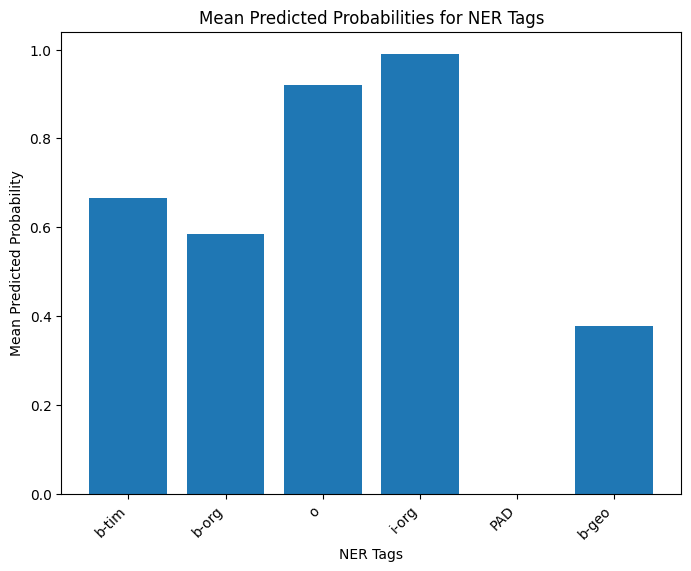

Word		Entity		Probability
----------------------------------------
The		o		0.8961
International		b-org		0.5845
Atomic		i-org		0.9902
Energy		i-org		0.9976
Agency		i-org		0.9837
is		o		0.9978
to		o		0.9996
hold		o		0.9975
second		o		0.9707
day		o		0.8625
of		o		0.9872
talks		o		0.9753
in		o		0.7376
Vienna		b-geo		0.3778
Wednesday		b-tim		0.6669
on		o		0.9598
how		o		0.9449
to		o		0.9542
respond		o		0.9873
to		o		0.7744
Iran		o		0.7520
's		o		0.8509
resumption		o		0.9614
of		o		0.9866
low-level		o		0.9942
uranium		o		0.9835
conversion		o		0.9581
.		o		0.7317


In [29]:


def predict_and_visualize_probabilities(sentence):
    """Predicts NER tags for a sentence and visualizes predicted probabilities.

    Args:
        sentence (str): The input sentence.
    """

    # Preprocess the input sentence
    input_seq = tokenizer.texts_to_sequences([sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_length, padding="post")

    # Make predictions
    predictions = model.predict(input_seq)[0]  # Get probabilities for each tag

    # Get predicted tags and their probabilities
    predicted_tags = np.argmax(predictions, axis=-1)
    predicted_probabilities = np.max(predictions, axis=-1)

    # Map predicted tags to their corresponding entity types
    predicted_entity_types = [tag_tokenizer.index_word.get(tag, "PAD") for tag in predicted_tags]

    # Create a list of tuples (word, entity_type, probability)
    results = [(word, entity, prob) for word, entity, prob in zip(sentence.split(), predicted_entity_types, predicted_probabilities)]

    # --- Visualization ---
# Get the number of words in the sentence
    num_words = len(sentence.split())
    # 1. Bar plot of predicted probabilities for all tokens
    plt.figure(figsize=(12, 4))
    plt.bar(sentence.split(), predicted_probabilities[:num_words]) 
    plt.xlabel("Words")
    plt.ylabel("Predicted Probability")
    plt.title("Predicted Probabilities for NER Tags")
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # 2. Box plot of predicted probabilities for each NER tag
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=predicted_entity_types, y=predicted_probabilities)
    plt.xlabel("NER Tags")
    plt.ylabel("Predicted Probability")
    plt.title("Distribution of Predicted Probabilities for NER Tags")
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # 3. Distribution of predicted probabilities for NER tags
    plt.figure(figsize=(8, 6))
    sns.histplot(predicted_probabilities, bins=10, kde=True)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.title("Distribution of Predicted Probabilities")
    plt.show()

    # 4. Mean Predicted Probabilities for NER Tags
    mean_probabilities = {}
    for entity_type in set(predicted_entity_types):
        mean_probabilities[entity_type] = np.mean(
            [prob for _, ent, prob in results if ent == entity_type]
        )

    plt.figure(figsize=(8, 6))
    plt.bar(mean_probabilities.keys(), mean_probabilities.values())
    plt.xlabel("NER Tags")
    plt.ylabel("Mean Predicted Probability")
    plt.title("Mean Predicted Probabilities for NER Tags")
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # Print the results
    print("Word\t\tEntity\t\tProbability")
    print("-" * 40)
    for word, entity, prob in results:
        print(f"{word}\t\t{entity}\t\t{prob:.4f}")

# Example usage:
sample_sentence = "The International Atomic Energy Agency is to hold second day of talks in Vienna Wednesday on how to respond to Iran 's resumption of low-level uranium conversion ."
predict_and_visualize_probabilities(sample_sentence)
